---

# Run tobac tracker on the regridded data 

## Imports

In [30]:
import numpy as np 
from pathlib import Path 
import xarray as xr 
import tobac 
print('For this cookbook, we are using tobac version:', tobac.__version__)

For this cookbook, we are using tobac version: 1.6.0


### Look at the distribution to verify that thresholds make sense

In [48]:
# read in the regridded data (from previous step)
mpas_regridded = xr.open_dataset("MPAS_regridded_2020_07_01.nc")

# read in the data into memory and change unit: g/m2 -> kg/m2
iwp = mpas_regridded.ice_water_path.compute() / 1000 

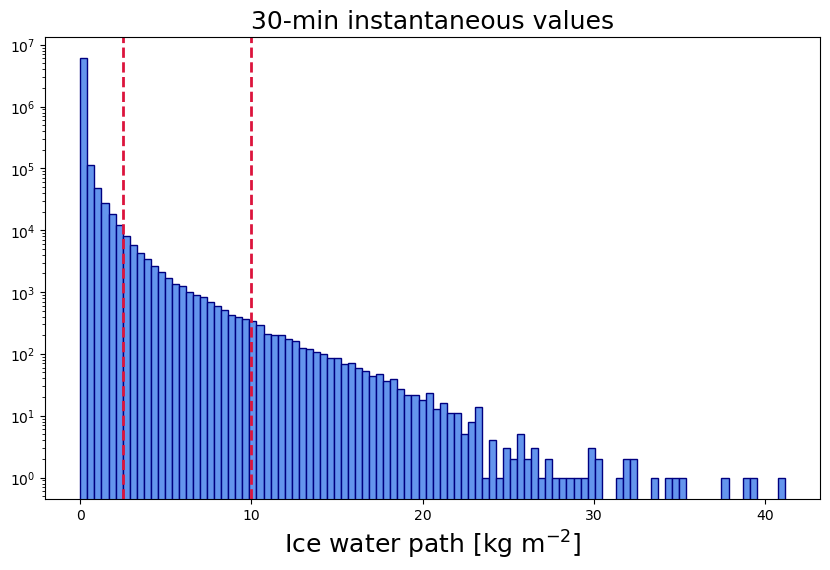

In [49]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,6))

fs = 18
plt.title('30-min instantaneous values', fontsize = fs)
plt.hist(iwp.isel(time = 0).values.flatten(), bins=100, log=True, color='cornflowerblue', edgecolor='navy')

thresholds = [2.5, 10]
for threshold in thresholds:
    plt.axvline(x=threshold, color='crimson', linestyle='--', linewidth=2, label='Threshold' + str(threshold))

plt.xlabel('Ice water path [kg m$^{-2}$]', fontsize = fs )
plt.show()

## Feature detection

The feature detection output is in form of a pandas dataframe, where each row corresponds to a unique detected feature in one timestep. 

[Detailed documentation of feature detection output](https://tobac.readthedocs.io/en/latest/feature_detection_output.html)

In [50]:
# set horizontal grid spacing [m] and temporal resolution [s]
dxy,dt= 111000, 1800 

# parameters for feature detection                                                           
parameters_features = {}
parameters_features['threshold']=[2.5, 10]  # thresholds for ice water path 
parameters_features['target']='maximum'
parameters_features['n_min_threshold']= 50  # minimum number of grid cells that need to be above specified threshold 

In [51]:
%%time 
input_data = iwp
storm_features = tobac.feature_detection_multithreshold(input_data, dxy, **parameters_features)

CPU times: user 13.6 s, sys: 392 ms, total: 14 s
Wall time: 14 s


## Tracking

The tracking output is in form of a pandas dataframe, where each row corresponds to a unique detected feature in one timestep. 

[Detailed documentation of tracking output](https://tobac.readthedocs.io/en/latest/tracking_output.html)

In [60]:
# parameters for linking 
parameters_linking={}
parameters_linking['v_max']= 50
# how many timesteps does the storm need to persist? 
parameters_linking['stubs']= 4 
parameters_linking['method_linking']= 'predict'
parameters_linking['PBC_flag'] ="hdim_2"
parameters_linking['min_h2'] = 0 
parameters_linking['max_h2'] = mpas_regridded.lon.size

In [83]:
%%time 
tracks = tobac.linking_trackpy(storm_features, None, dt=dt, dxy=dxy, **parameters_linking)
tracks = tracks[tracks.cell > 0] # removes invalid cells 
tracks = tracks.reset_index(drop=True)

Frame 47: 99 trajectories present.
CPU times: user 689 ms, sys: 32.3 ms, total: 721 ms
Wall time: 695 ms


In [84]:
print(tracks.cell.unique().size, 'individual tracks')

49 individual tracks


In [85]:
tracks.head()

,frame,idx,hdim_1,hdim_2,num,threshold_value,feature,time,timestr,lat,lon,ncells,max_iwp,total_iwp,mean_iwp,cell,time_cell
0,0,1438,962.170213,1843.797872,94,2.5,52,2020-07-01 00:00:00,2020-07-01 00:00:00,6.217021,4.379787,174,19.396437,717.833252,4.125478,52,0 days 00:00:00
1,0,1809,1045.127083,707.841667,480,2.5,64,2020-07-01 00:00:00,2020-07-01 00:00:00,14.512708,-109.215833,1943,23.331123,4343.843262,2.235637,64,0 days 00:00:00
2,0,2119,1162.725490,2557.274510,51,2.5,75,2020-07-01 00:00:00,2020-07-01 00:00:00,26.272549,75.727451,96,25.83609,442.057312,4.604764,75,0 days 00:00:00
3,0,2935,1602.132353,356.352941,68,2.5,124,2020-07-01 00:00:00,2020-07-01 00:00:00,70.213235,-144.364706,757,8.381392,948.486938,1.252955,124,0 days 00:00:00
4,1,1470,961.965517,1843.396552,116,2.5,178,2020-07-01 00:30:00,2020-07-01 00:30:00,6.196552,4.339655,200,20.081499,848.819946,4.2441,52,0 days 00:30:00


Storms that have a cell ID of -1 mean that those features are not connected over time because they do not fulfill the minimum requirement for duration. 

## Segmentation of the tracked storm objects

In this step, we define the storm extent (using watershedding) and we can calculate some bulk metrics for the storm objects detected in each timestep. The output are the updated feature pandas dataframe and an xarray.DataArray that contains the storm object mask (with the same dimensions as the regridded input data). 

[Detailed documentation of segmentation output](https://tobac.readthedocs.io/en/latest/segmentation_output.html)

The segmentation is usually the step that takes the longest time, whereas the tracking should be fastest. 

In [86]:
# parameters for segmentation 
parameters_segmentation = {}
parameters_segmentation['threshold']= 0.25 # kg/m2 used to define the extent of the cloud objects                     
parameters_segmentation['target'] = "maximum"
parameters_segmentation['statistic'] = {"max_iwp": np.nanmax, 'total_iwp': np.nansum, 'mean_iwp': np.nanmean}

In [87]:
%%time 
mask, storm_features = tobac.segmentation_2D(tracks, input_data, dxy, **parameters_segmentation)

CPU times: user 2min 21s, sys: 705 ms, total: 2min 22s
Wall time: 2min 22s


In [88]:
storm_features.head()

,frame,idx,hdim_1,hdim_2,num,threshold_value,feature,time,timestr,lat,lon,ncells,max_iwp,total_iwp,mean_iwp,cell,time_cell
0,0,1438,962.170213,1843.797872,94,2.5,52,2020-07-01 00:00:00,2020-07-01 00:00:00,6.217021,4.379787,174,19.396437,717.833374,4.125479,52,0 days 00:00:00
1,0,1809,1045.127083,707.841667,480,2.5,64,2020-07-01 00:00:00,2020-07-01 00:00:00,14.512708,-109.215833,1943,23.331123,4343.843262,2.235637,64,0 days 00:00:00
2,0,2119,1162.725490,2557.274510,51,2.5,75,2020-07-01 00:00:00,2020-07-01 00:00:00,26.272549,75.727451,96,25.83609,442.057281,4.604764,75,0 days 00:00:00
3,0,2935,1602.132353,356.352941,68,2.5,124,2020-07-01 00:00:00,2020-07-01 00:00:00,70.213235,-144.364706,1949,11.143545,2550.856689,1.308803,124,0 days 00:00:00
4,1,1470,961.965517,1843.396552,116,2.5,178,2020-07-01 00:30:00,2020-07-01 00:30:00,6.196552,4.339655,200,20.081499,848.819824,4.244099,52,0 days 00:30:00


### Save tracking output (optional, but practical in most cases)

In [90]:
output_dir = Path('.') # change output directory according to your needs 

feature_file_name = 'MPAS_tobac_storm_features_iwp.nc' # all detected features, also those not linked over time
track_file_name = 'MPAS_tobac_storm_tracks_iwp.nc'
mask_file_name = 'MPAS_tobac_storm_mask_iwp.nc'

storm_features.to_xarray().to_netcdf(output_dir / feature_file_name)
tracks.to_xarray().to_netcdf(output_dir / track_file_name)
mask.to_netcdf(output_dir / mask_file_name)

---